# Local2Global example

In [1]:
import geotorch
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import local2global as l2g
import local2global.example as ex
from scipy.stats import ortho_group 
from tqdm.notebook import tqdm
import geotorch
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import local2global as l2g
import local2global.example as ex
import local2global_embedding
from scipy.stats import ortho_group 
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix
import random
#import manopt_optimization as moptim
from torch_geometric.data import Data
import torch_geometric as tg
from local2global_embedding.network import tgraph
from local2global_embedding.patches import create_patch_data
from local2global_embedding.clustering import louvain_clustering
from torch_geometric.utils.convert import from_networkx
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import local2global as l2g
import local2global.example as ex
import local2global_embedding


import torch_geometric as tg
import pandas as pd
from torch_geometric.data import Data
import torch_scatter as ts

import glob
import os

from scipy.linalg import sqrtm
from scipy.sparse import diags


import scipy.sparse as ss
import scipy.sparse.linalg as sl

from local2global import Patch
import Local2Global_embedding.local2global_embedding.embedding.svd as svd
import Local2Global_embedding.local2global_embedding.embedding.gae as gae

import matplotlib.cm as cm
from tqdm.notebook import tqdm
import glob

In [2]:
def loss_at_node_patch_p(p, node, rots, shifts, scales, patches):
    i=patches.index(p)
    q=patches[i+1]    
    #rots=[torch.tensor(r) for r in rots]
    #shifts=[torch.tensor(s) for s in shifts]
    #scales=[torch.tensor(s) for s in scales]
    return torch.norm( scales[i]*p.get_coordinate(node)@rots[i] + shifts[i] -(scales[i+1]*q.get_coordinate(node)@rots[i+1] +shifts[i+1]))**2
        
def grad_loss_at_node_patch_p(p, node, rots,shifts, scales, patches):
    i=patches.index(p)
    W=rots[i].clone().detach().requires_grad_(True)
    rots[i]=W
    g=loss_at_node_patch_p(p, node, rots,shifts, scales, patches).clone().detach().requires_grad_(True)
    W.retain_grad()
    g.backward()
    return W.grad
        

def min_loss(Rotations, scales, translations , patches, nodes):
    l=0
    fij=dict()
    for i, p in enumerate(patches[:len(patches)-1]):
        q=patches[i+1]
        for n in nodes[i,i+1]:
            theta1=scales[i]*p.get_coordinate(n)@Rotations[i]+ translations[i]
            theta2= scales[i+1]*q.get_coordinate(n)@Rotations[i+1]+translations[i+1]
            l+=np.linalg.norm(theta1-theta2)**2
            #fij[(i, j+1+i, n)]=[theta1, theta2]
    return l#, fij

def numbering_tangent_coordinates(dim):
    numb= dict()
    jl=[]
    for j in range(dim):
        for l in range(j+1, dim):
            jl.append((j,l))
    for i in range(len(jl)):
        numb[i]=jl[i]
    return numb

def get_coordinates_from_index(i, dim):
    return numbering_tangent_coordinates(dim)[i]


def select_coordinate(X):
    return torch.argmax(torch.norm(X, dim=0)).item()

def basis(j, l, dim):
    ej=torch.zeros((dim,1))
    ej[j]=1
    el=torch.zeros((dim,1))
    el[l]=1
    return 1/np.sqrt(2)* (ej@el.t() - el@ej.t()).numpy() #.type(torch.float64)
    


#def grad_s_X_R_norm(scale, emb, rot):
    #rot=torch.tensor(rot, requires_grad=True)
    #pr=torch.norm(scale*emb@rot)**2
    #pr.backward()
    #return rot.grad
def grad_s_X_R_norm(scale, emb, rot):
    return 2*scale**2*emb*rot


def grad_s_X_R_scalar_y(scale, emb ,rot, y):
    #rot=torch.tensor(rot, requires_grad=True)
    
    #pr=torch.dot((scale*emb@rot).to(torch.float32), shift.to(torch.float32))
    #pr.backward()
    return 2*scale*emb@rot@y

def EU_grad_R(p, dict_nodes, rots, shifts, scales, patches):
    
    i=patches.index(p)
    W=rots[i]
    s=scales[i]
    dim=np.shape(W)[0]
    #W=torch.tensor(rots[i])
    if i==len(patches)-1:
        p_=patches[i-1]
        s_=scales[i-1]
        t_=shifts[i-1]
        R_=rots[i-1]
        grad=np.zeros((dim, dim)) #0
        for node in dict_nodes[i-1, i]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            grad+=grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, shifts[i]) - grad_s_X_R_scalar_y(s, X, W, theta)
        return grad
    else:
        p_=patches[i+1]
        s_=scales[i+1]
        t_=shifts[i+1]
        R_=rots[i+1]
        grad=np.zeros((dim, dim)) #0
        for node in dict_nodes[i, i+1]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            grad+=grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, shifts[i]) - grad_s_X_R_scalar_y(s, X, W, theta)
        if i==0:
            return grad
        else:
            p_=patches[i-1]
            s_=scales[i-1]
            t_=shifts[i-1]
            R_=rots[i-1]
            for node in dict_nodes[i-1, i]:
                X=p.get_coordinate(node)
                Y=p_.get_coordinate(node)
                theta=s_*Y@R_ + t_
                grad+=grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, shifts[i]) - grad_s_X_R_scalar_y(s, X, W, theta)
            return grad
        
        
def grad_s(p, dict_nodes, rots, shifts, scales, patches):
    i=patches.index(p)
    s=scales[i]
    #W=torch.tensor(rots[i])
    if i==len(patches)-1:
        p_=patches[i-1]
        s_=scales[i-1]
        t_=shifts[i-1]
        R_=rots[i-1]
        grad=0
        for node in dict_nodes[i-1, i]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            X_R=X@rots[i]
            grad+=2*s*np.linalg.norm(X_R) + 2*X_R@shifts[i] - 2*X_R@theta
        return grad
    else:
        p_=patches[i+1]
        s_=scales[i+1]
        t_=shifts[i+1]
        R_=rots[i+1]
        grad=0
        for node in dict_nodes[i, i+1]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            X_R=X@rots[i]
            grad+=2*s*np.linalg.norm(X_R) + 2*X_R@shifts[i] - 2*X_R@theta
        if i==0:
            return grad
        else:
            p_=patches[i-1]
            s_=scales[i-1]
            t_=shifts[i-1]
            R_=rots[i-1]
            for node in dict_nodes[i-1, i]:
                X=p.get_coordinate(node)
                Y=p_.get_coordinate(node)
                theta=s_*Y@R_ + t_
                X_R=X@rots[i]
                grad+=2*s*np.linalg.norm(X_R) + 2*X_R@shifts[i] - 2*X_R@theta
            return grad
            
def grad_t(p, dict_nodes, rots, shifts, scales, patches):
    i=patches.index(p)
    s=scales[i]
    #W=torch.tensor(rots[i])
    if i==len(patches)-1:
        p_=patches[i-1]
        s_=scales[i-1]
        t_=shifts[i-1]
        R_=rots[i-1]
        grad=np.zeros(np.shape(shifts[0]))
        for node in dict_nodes[i-1, i]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            s_X_R=s*X@rots[i]
            grad+=2*(s_X_R + shifts[i] - theta)
        return grad
    else:
        p_=patches[i+1]
        s_=scales[i+1]
        t_=shifts[i+1]
        R_=rots[i+1]
        grad=np.zeros(np.shape(shifts[0]))
        for node in dict_nodes[i, i+1]:
            X=p.get_coordinate(node)
            Y=p_.get_coordinate(node)
            theta=s_*Y@R_ + t_
            s_X_R=s*X@rots[i]
            grad+=2*(s_X_R + shifts[i] - theta)
        if i==0:
            return grad
        else:
            p_=patches[i-1]
            s_=scales[i-1]
            t_=shifts[i-1]
            R_=rots[i-1]
            for node in dict_nodes[i-1, i]:
                X=p.get_coordinate(node)
                Y=p_.get_coordinate(node)
                theta=s_*Y@R_ + t_
                s_X_R=s*X@rots[i]
                grad+=2*(s_X_R + shifts[i] - theta)
            return grad


def euclidean_grad_loss(W, p ,node, rots, shifts, scales, patches):
    i=patches.index(p)
    if i==len(patches):
        q=patches[i-1]
        theta=scales[i-1]*q.get_coordinate(node)@rots[i-1]
    else:
        q=patches[i+1]
        theta=scales[i+1]*q.get_coordinate(node)@rots[i+1]
    s=scales[i]
    W=torch.tensor(rots[i])#, requires_grad=True)
    X=torch.tensor(p.get_coordinate(node))
    Y=torch.tensor(q.get_coordinate(node))
        
    if i==0 or i==len(patches):
        return grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, torch.tensor(shifts[i])) - grad_s_X_R_scalar_y(s, X, W, torch.tensor(theta))
    else:
        if node in set(patches[i-1].nodes):
            theta2=scales[i-1]*patches[i-1].get_coordinate(node)@rots[i-1]
            return 2*(grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, torch.tensor(shifts[i])))- grad_s_X_R_scalar_y(s, X, W, torch.tensor(theta +theta2))
        else:
            return grad_s_X_R_norm(s, X, W) + grad_s_X_R_scalar_y(s, X, W, torch.tensor(shifts[i])) - grad_s_X_R_scalar_y(s, X, W, torch.tensor(theta))

    
def riemannian_gradient(eucl_grad_h, W):
    #dim=np.shape(W)[0]
   # D=int(0.5*dim*(dim-1))
    #r_grad=[]
    #for index in range(D):
        #j=get_coordinates_from_index(index, dim)[0]
        #l=get_coordinates_from_index(index, dim)[1]
        #Hjl=basis(j, l, dim)
        #r_grad.append(np.trace(Hjl.t()@np.transpose(W)@eucl_grad_h))
    #W=torch.tensor(W)
    return 0.5*(eucl_grad_h- W@np.transpose(eucl_grad_h)@W  )                  #torch.tensor(r_grad)


def givens_matrix(j, l, alpha, dim):

    
    row_col = torch.tensor([list(range(dim))+ [j, l], 
                 list(range(dim))+  [l, j ]])

    values=torch.tensor([1] * j +
                 [np.cos(alpha)] + 
                 [1] * (l-j-1) + 
                 [np.cos(alpha)] + 
                 [1]*(dim-l-1) +
                 [np.sin(alpha) , -np.sin(alpha)],
                dtype=torch.float64)
    row=row_col[0,:].numpy()
    col=row_col[1,:].numpy()

    S=torch.sparse_coo_tensor(row_col, values, [dim, dim])
    T= coo_matrix((values, (row, col)), shape=(dim, dim))


    return  T
#def grad_s():
    
    
    
def update(W, grad, alpha, index):
    dim=np.shape(W)[0]
    jl=get_coordinates_from_index(index, dim)
    j=jl[0]
    l=jl[1]
    Hjl=basis(j,l,dim)
    W=torch.tensor(W)
    eta=W@Hjl
    grad_eta=torch.trace(grad.t()@eta)
    grad_direction_index=grad_eta*eta
    givens_m=givens_matrix(j, l, -alpha*grad_eta, dim)
    W_new=torch.sparse.mm(W, givens_m)
    return W_new
   




def one_step_rie_grad_descent( p,patches, dict_nodes, rots, shifts, scales, alpha, tang_basis):
    W=rots[patches.index(p)]
    s=scales[patches.index(p)]
    t=shifts[patches.index(p)]
    dim=np.shape(W)[0]
    D=int(0.5*dim*(dim-1))
    e_grad=EU_grad_R(p, dict_nodes, rots, shifts, scales, patches)
    t_grad=grad_t(p, dict_nodes, rots, shifts, scales, patches)
    s_grad=grad_s(p, dict_nodes, rots, shifts, scales, patches)
    s_new=s-alpha*s_grad
    t_new=t-alpha*t_grad
    #for n in nodes:
        #e_grad.append(euclidean_grad_loss(W, p ,n, rots, shifts, scales, patches))

    #e_grad=sum(e_grad)
    #W=torch.tensor(W)

    tang_basis=[W@e for e in tang_basis]
    
    R_grad=0.5*(e_grad- W@np.transpose(e_grad)@W  ) #riemannian_gradient(e_grad, W)
    g_W_i=np.stack([ np.trace(np.transpose(R_grad)@ e)*e for e in tang_basis])


    index=np.argmax([np.trace(np.transpose(g_W_i[i,:,:])@g_W_i[i,:,:]) for i in range(D)])
    grad_eta_direction_index=g_W_i[index]
    phi=np.trace(np.transpose(R_grad)@ tang_basis[index])
    jl=get_coordinates_from_index(index, dim)
    j=jl[0]
    l=jl[1]
    givens_m=givens_matrix(j, l, -alpha*phi, dim)
    W_new=W@givens_m #torch.sparse.mm(W, givens_m) 
    return W_new, t_new, s_new
        
        
        
def optimize_rotations(list_of_patches, dict_nodes, list_rots, list_shifts, list_scales, learning_rate, tangent_space_basis):
    #rots=[ortho_group.rvs(dim=5) for i in range(n_patches)]
    n_patches=len(list_of_patches)
    for i, p in enumerate(list_of_patches[:n_patches]):
        W_new, t_new, s_new=one_step_rie_grad_descent(p, list_of_patches, dict_nodes, list_rots, list_shifts, list_scales, learning_rate, tangent_space_basis)
        list_rots[i]=W_new #.numpy()
        list_shifts[i]=t_new
        list_scales[i]=s_new
    return list_rots, list_shifts, list_scales
        
def optimize_rotations_two_patches(list_of_patches, dict_nodes, list_rots, list_shifts, list_scales, learning_rate, tangent_space_basis):
    #rots=[ortho_group.rvs(dim=5) for i in range(n_patches)]
    nodes=list(dict_nodes.values())[0]
    P=list_of_patches[0]
    Q=list_of_patches[1]
    if len(nodes)>0:
        W1_new=one_step_rie_grad_descent(P, list_of_patches, nodes, list_rots, list_shifts, list_scales, learning_rate, tangent_space_basis)
        list_rots[0]=W1_new.numpy()
        W2_new=one_step_rie_grad_descent(Q, list_of_patches[::-1], nodes[::-1], list_rots[::-1], list_shifts[::-1], list_scales[::-1], learning_rate, tangent_space_basis)
        list_rots[1]=W2_new.numpy()
    return list_rots    

In [3]:
how_many_patches=2

In [4]:
file_list = glob.glob(os.path.join(os.getcwd(), "Data/AS", "*.txt"))

corpus = [np.loadtxt(file).astype('int64') for file in sorted(file_list[:how_many_patches])]
data=corpus

graphs=[nx.from_edgelist(list(g)) for g in tqdm(data)]
tgraphs=[from_networkx(G) for G in tqdm(graphs)]

for i, p in enumerate(tgraphs):
    p.nodes=torch.Tensor(list(graphs[i].nodes)).int()

import torch.nn.functional as F
def speye(n, dtype=torch.float):
    """identity matrix of dimension n as sparse_coo_tensor."""
    return torch.sparse_coo_tensor(torch.tile(torch.arange(n, dtype=torch.long), (2, 1)),
                                   torch.ones(n, dtype=dtype),
                                   (n, n))

class VGAEconv(torch.nn.Module):
    def __init__(self, dim, num_node_features, hidden_dim=32, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, hidden_dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                   normalize=normalize)
        self.mean_conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                        normalize=normalize)
        self.var_conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                       normalize=normalize)

    def forward(self, data: tg.data.Data):
        x = data.x
        edge_index = data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        mu = self.mean_conv2(x, edge_index)
        sigma = self.var_conv2(x, edge_index)
        return mu, sigma

def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        logger(float(loss))
        if verbose:
            print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model

def VGAE_patch_embeddings(patch_data, dim=100, hidden_dim=32, num_epochs=100, decoder=None, device='cpu', lr=0.01):
    patch_list = []
    models = []
    for patch in patch_data:
        if patch.x is None:
            patch.x = speye(patch.num_nodes)
            print(f"training patch with {patch.edge_index.shape[1]} edges")   #added [i] to every patch
            model = tg.nn.VGAE(encoder=VGAEconv(dim, patch.x.shape[1], hidden_dim=hidden_dim), decoder=decoder).to(device)
            patch.to(device)

        def loss_fun(model, data):
            return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes

        model = train(patch, model, loss_fun, num_epochs=num_epochs, lr=lr)
        with torch.no_grad():
            model.eval()
            coordinates = model.encode(patch).to('cpu').numpy()
            models.append(model)
            patch_list.append(l2g.Patch(patch.nodes.to('cpu').numpy(), coordinates))
    return patch_list, models

patches, AS_model=VGAE_patch_embeddings(tgraphs, dim=10 ,hidden_dim=32, num_epochs=50, decoder=None, device='cpu', lr=0.01)

from itertools import chain

def nodes_in_all_patches(ptchs):
    n=[list(p.nodes) for p in ptchs]
    list(chain.from_iterable(n))
    
    return list(set(list(chain.from_iterable(n))))





all_patches=nodes_in_all_patches(patches)



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

training patch with 19751 edges
epoch 0: loss=2.875016927719116
epoch 1: loss=2.6710448265075684
epoch 2: loss=2.5728635787963867
epoch 3: loss=2.4400687217712402
epoch 4: loss=2.3386542797088623
epoch 5: loss=2.2120521068573
epoch 6: loss=2.1006412506103516
epoch 7: loss=2.0732264518737793
epoch 8: loss=1.9376322031021118
epoch 9: loss=1.840653419494629
epoch 10: loss=1.780288815498352
epoch 11: loss=1.7158204317092896
epoch 12: loss=1.6678345203399658
epoch 13: loss=1.5805283784866333
epoch 14: loss=1.525348424911499
epoch 15: loss=1.463024616241455
epoch 16: loss=1.4228763580322266
epoch 17: loss=1.373339295387268
epoch 18: loss=1.349448800086975
epoch 19: loss=1.3095217943191528
epoch 20: loss=1.2796279191970825
epoch 21: loss=1.2494723796844482
epoch 22: loss=1.2350984811782837
epoch 23: loss=1.2062488794326782
epoch 24: loss=1.1967257261276245
epoch 25: loss=1.1831563711166382
epoch 26: loss=1.1646925210952759
epoch 27: loss=1.1570782661437988
epoch 28: loss=1.1449347734451294
ep

In [5]:
intersections=dict()
for i in range(len(patches)-1):
    intersections[i,i+1]=set(patches[i].nodes).intersection(set(patches[i+1].nodes))

In [6]:
dim=10
n_patches=len(patches)
scales=np.random.randn(len(patches)) #ones(len(patches))
shifts=np.random.rand(len(patches), dim)
alpha=0.00005
D=int(0.5*dim*(dim-1))
tang_basis=[]
for i in range(D):
    j=numbering_tangent_coordinates(dim)[i][0]
    l=numbering_tangent_coordinates(dim)[i][1]
    tang_basis.append(basis(j, l, dim))                  
#rots=[np.eye(5)for i in range(n_patches)]

rots=[ortho_group.rvs(dim=dim) for i in range(n_patches)]

In [7]:
l=min_loss(rots, scales, shifts , patches, intersections)
l

9267.218793440446

In [8]:
l=min_loss(rots, scales, shifts , patches, intersections)
loss_hist=[]
for k in tqdm(range(10)):
    rots, shifts, scales= optimize_rotations(patches, intersections, rots, shifts, scales, alpha, tang_basis)
    loss=min_loss(rots, scales, shifts , patches, intersections)
    loss_hist.append(loss)
    if k%5==0:
        print(f"loss: {loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

loss: 1770.9086588608534
loss: 47.60656997530244


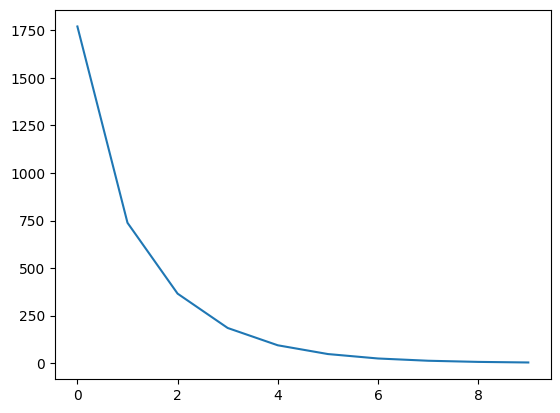

In [9]:
plt.plot(loss_hist)

In [10]:
emb_problem = l2g.AlignmentProblem(patches)
for i, p in enumerate(emb_problem.patches):
    p.coordinates=scales[i]*p.coordinates@rots[i] + shifts[i]
embedding = np.empty((emb_problem.n_nodes, emb_problem.dim))
for node, patch_list in enumerate(emb_problem.patch_index):
    embedding[node] = np.mean([emb_problem.patches[p].get_coordinate(node) for p in patch_list], axis=0)


/home/mathscdt/pytorch_env/my_project_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mathscdt/pytorch_env/my_project_env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [11]:
import umap
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')

2025-01-22 16:39:13.425893: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-22 16:39:13.463818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-22 16:39:14.234750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
all_nodes=[]
for p in patches:
    all_nodes.append(list(p.nodes))

In [13]:
import itertools
all_nodes=list(itertools.chain.from_iterable(all_nodes))
all_nodes=list(set(all_nodes))


In [15]:
old=l2g.AlignmentProblem(patches)
old_emb=old.get_aligned_embedding()

Compute relative transformations:   0%|          | 0/2 [00:00<?, ?it/s]

Compute mean embedding:   0%|          | 0/2 [00:00<?, ?it/s]

/home/mathscdt/pytorch_env/my_project_env/lib/python3.8/site-packages/local2global/utils.py:438: RuntimeWarning: invalid value encountered in divide
  embedding /= count[:, None]


In [16]:
old_emb_no_nan=old_emb[all_patches, :]
umap_old_emb=reducer.fit_transform(old_emb_no_nan)

In [17]:
emb_no_nan=embedding[all_patches, :]


In [18]:
umap_embedding = reducer.fit_transform(emb_no_nan)

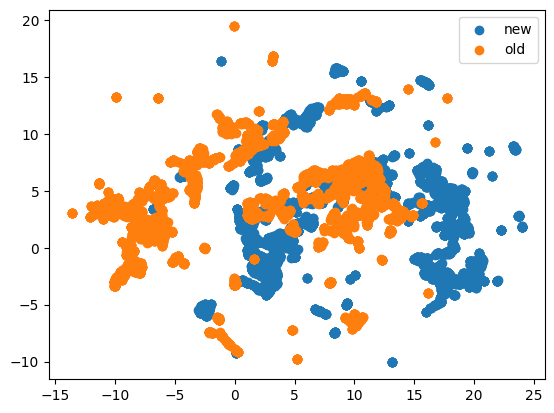

In [19]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1],  label='new')
plt.scatter(umap_old_emb[:,0], umap_old_emb[:,1], label= 'old')
plt.legend()
plt.show()